# <center>Project-Based Assignment CLO-2</center>

<b>Topic</b>
Implementation of Supervised Learning on Regression Task

<b>Group Member</b>
1. Fauzan Rizqi Muhammad - 1301213181
2. Anaz Akbar Azhar - 1301213291
3. Ridla Aliya Gani - 1301213042

#### Background
Energy efficiency is crucial for sustainability, and accurate estimation of heating load requirements is paramount. The Energy Efficiency dataset, comprising 768 samples with 8 features, offers a foundation for this analysis. The eight features encompass building parameters such as relative compactness, surface area, orientation, and glazing area, which significantly impact energy efficiency. The goal is to predict heating loads, aiding architects and engineers in informed decision-making. Support Vector Machines (SVM), a robust machine learning algorithm, are employed for this task. SVM's ability to find optimal hyperplanes maximizes predictive accuracy. This research seeks to enhance building energy efficiency, shedding light on the relationship between building parameters and load requirements for more sustainable and cost-effective building design and operation.

Install necessary library



In [ ]:
%pip install gdown
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn

In [ ]:
!gdown --id 1rTwzM1qluJHB9HpP9w2cQEsCrOC1DFlb #Download the file from the goole drive

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rTwzM1qluJHB9HpP9w2cQEsCrOC1DFlb
To: /content/energy_efficiency.csv
100% 40.1k/40.1k [00:00<00:00, 81.5MB/s]


Import necessary library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

Read the data

In [ ]:
data = pd.read_csv('/content/energy_efficiency.csv')

Checking Misssing Values first

In [ ]:
missing_values = data.isnull().sum()
print(missing_values,'\n')

Relative_Compactness         0
Surface_Area                 0
Wall_Area                    0
Roof_Area                    0
Overall_Height               0
Orientation                  0
Glazing_Area                 0
Glazing_Area_Distribution    0
Heating_Load                 0
Cooling_Load                 0
dtype: int64 



Checking datatypes to ensure we are dealing with numeric data


In [ ]:
data.dtypes

Relative_Compactness         float64
Surface_Area                 float64
Wall_Area                    float64
Roof_Area                    float64
Overall_Height               float64
Orientation                    int64
Glazing_Area                 float64
Glazing_Area_Distribution      int64
Heating_Load                 float64
Cooling_Load                 float64
dtype: object

In [ ]:
data.head(10)

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
5,0.90,563.5,318.5,122.50,7.0,3,0.0,0,21.46,25.38
6,0.90,563.5,318.5,122.50,7.0,4,0.0,0,20.71,25.16
7,0.90,563.5,318.5,122.50,7.0,5,0.0,0,19.68,29.60
8,0.86,588.0,294.0,147.00,7.0,2,0.0,0,19.50,27.30
9,0.86,588.0,294.0,147.00,7.0,3,0.0,0,19.95,21.97


Check correlation for the data



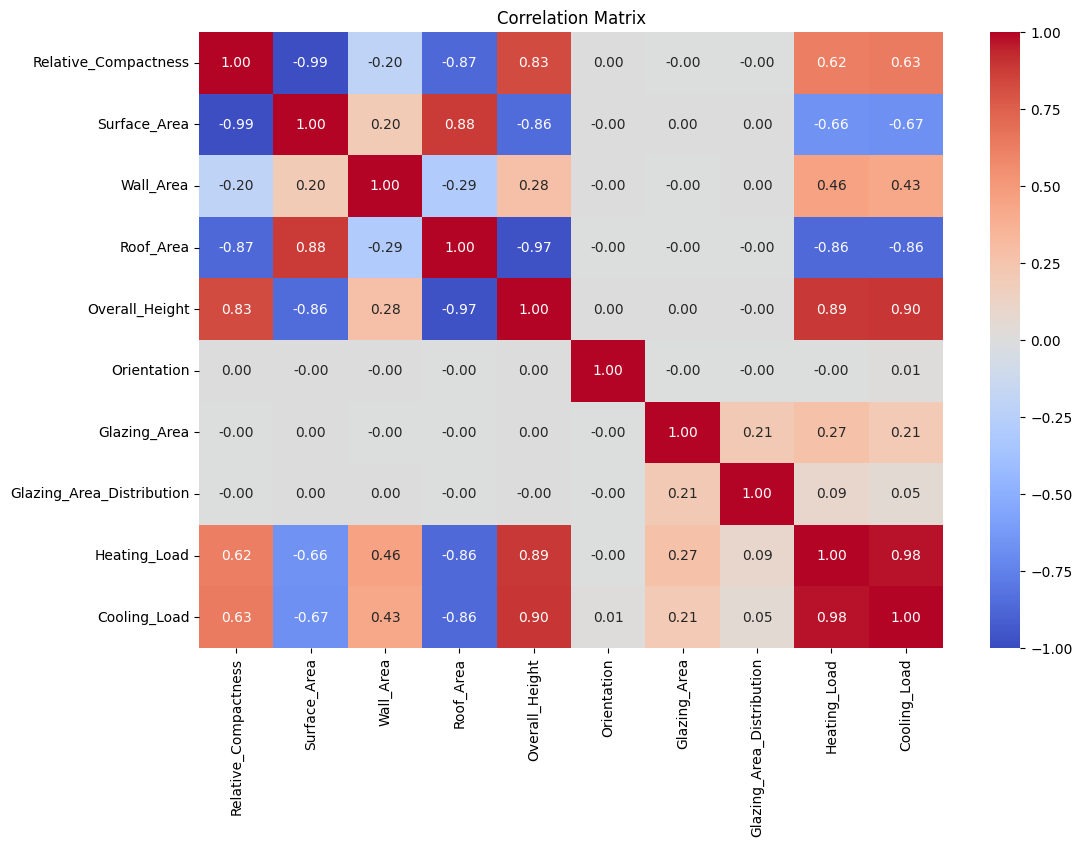

In [ ]:
# Calculating the correlation matrix for the original data
correlation_matrix = data.corr()
# Visualizing the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


Glazing_Area_Distribution and Orientation seems has little correlation to Heating_Load and Cooling_Load

Data that has little to not correlation better to be dropped because it can disturb the result of the data when being trained

In [ ]:
data_cleaned = data.drop(columns=['Glazing_Area_Distribution', 'Orientation'])

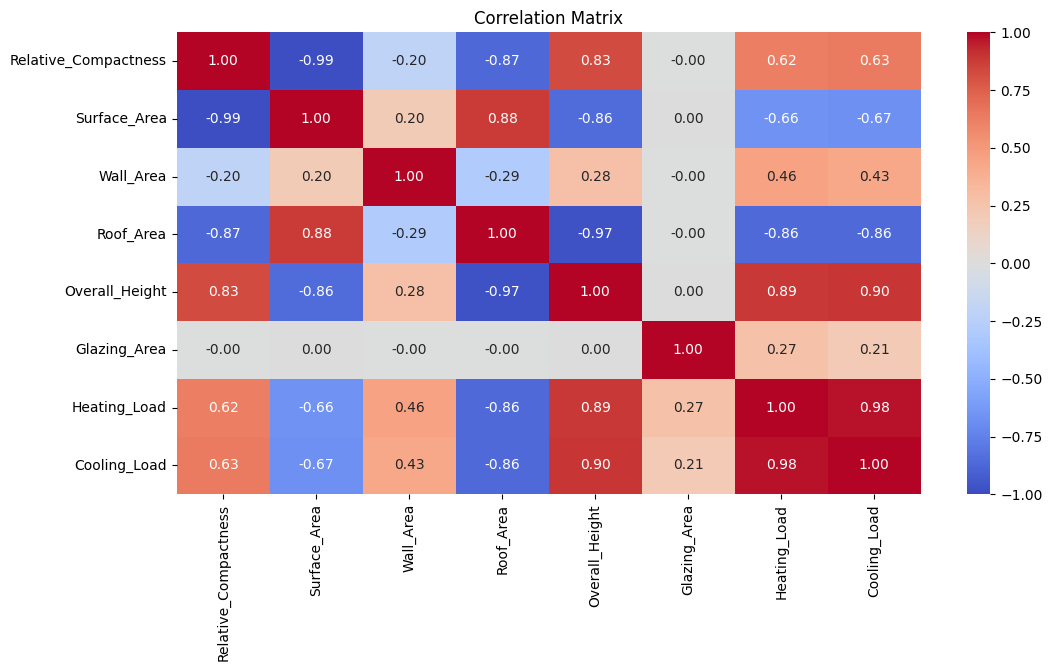

In [ ]:
# Calculating the correlation matrix for the original data
correlation_matrix = data_cleaned.corr()
# Visualizing the correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Check outliers because SVM is sensitive to the outliers. Outliers can lead to some biased data

**Threshold**

* The threshold determines how many times the MAD a data point must be away from the median to be considered an outlier.
* A higher threshold means that a data point must be more extreme to be considered an outlier, potentially leading to fewer outliers being detected.
* A lower threshold makes the criteria for being an outlier more lenient, potentially leading to more outliers being detected.

In [ ]:
# Function to calculate MAD and identify outliers
def identify_outliers_mad(data_cleaned, threshold=4):
    median = np.median(data_cleaned)
    mad = np.median(np.abs(data_cleaned - median))
    mad_score = (np.abs(data_cleaned - median)) / mad
    outliers = mad_score > threshold
    return outliers.sum()

# Identifying outliers using MAD
outliers_mad = data_cleaned.apply(lambda x: identify_outliers_mad(x, threshold=3))
outliers_mad_percentage = (outliers_mad / len(data_cleaned)) * 100

mad_outlier_data = pd.DataFrame({
    'Outliers': outliers_mad,
    'Percentage (%)': outliers_mad_percentage
})

mad_outlier_data[mad_outlier_data['Outliers'] > 0]


,Outliers,Percentage (%)
Wall_Area,64,8.333333
Heating_Load,14,1.822917
Cooling_Load,14,1.822917


We try to fix the outlier from the data using several method like log, squareroot, or cubic root and we run all of them to see which one is the best.

Log or `numpy.log1p` in NumPy calculates the natural logarithm of `1 + x` element-wise for the input array `x`. It handles real and complex inputs, provides options for result storage and conditional computation, and ensures accuracy even for small input values. The output is an ndarray with real values or 'nan' for invalid inputs, following conventions for multivalued logarithmic functions.

Squareroot ot `numpy.sqrt` in NumPy computes the non-negative square root of an array element-wise. It returns an array with positive square roots of the input. You can specify output location and condition. If input contains complex numbers, output is complex, handling square roots of negative reals with 'nan'. For all real inputs, the output is real, with negative values as 'nan'. The function's branch cut is at the interval [-inf, 0), and it's continuous from above on this interval in the complex plane.

Cubic root or `numpy.cbrt` in NumPy computes the cube root of an array element-wise. It returns an array with the cube root of each element in the input. You can specify output location and condition. The function is introduced in NumPy version 1.10.0.

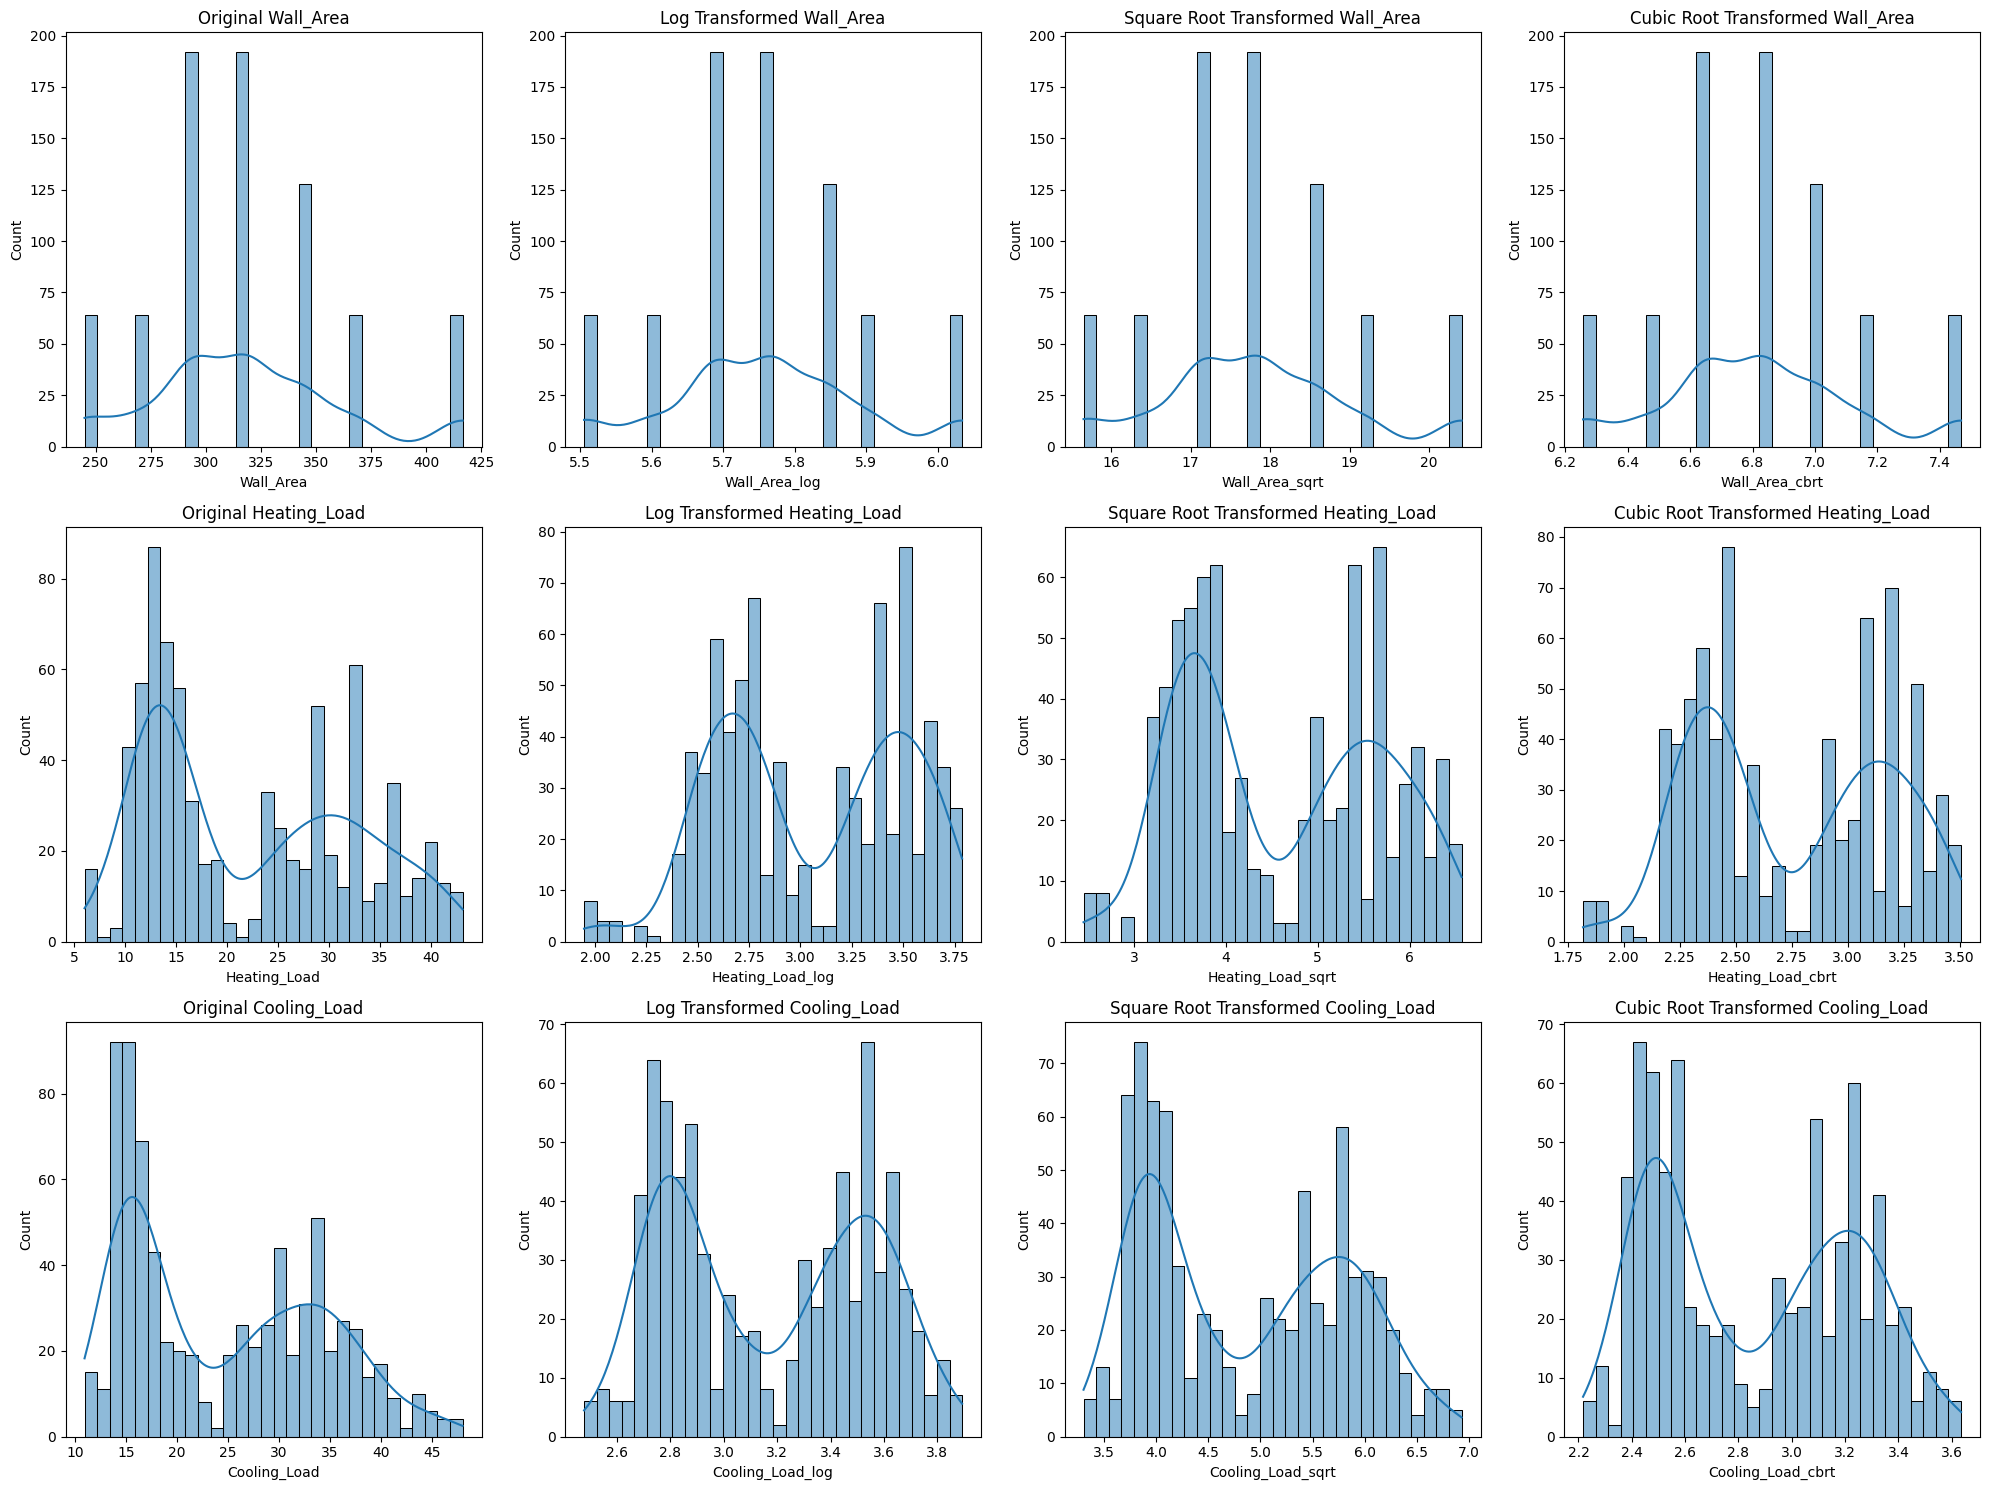

In [ ]:
data_transformed = data_cleaned.copy()
data_transformed['Wall_Area_log'] = np.log1p(data_cleaned['Wall_Area'])
data_transformed['Heating_Load_log'] = np.log1p(data_cleaned['Heating_Load'])
data_transformed['Cooling_Load_log'] = np.log1p(data_cleaned['Cooling_Load'])

data_transformed['Wall_Area_sqrt'] = np.sqrt(data_cleaned['Wall_Area'])
data_transformed['Heating_Load_sqrt'] = np.sqrt(data_cleaned['Heating_Load'])
data_transformed['Cooling_Load_sqrt'] = np.sqrt(data_cleaned['Cooling_Load'])

data_transformed['Wall_Area_cbrt'] = np.cbrt(data_cleaned['Wall_Area'])
data_transformed['Heating_Load_cbrt'] = np.cbrt(data_cleaned['Heating_Load'])
data_transformed['Cooling_Load_cbrt'] = np.cbrt(data_cleaned['Cooling_Load'])

# Visualizing the results
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

# Original Data
sns.histplot(data_cleaned['Wall_Area'], bins=30, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Original Wall_Area')
sns.histplot(data_cleaned['Heating_Load'], bins=30, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Original Heating_Load')
sns.histplot(data_cleaned['Cooling_Load'], bins=30, kde=True, ax=axs[2, 0])
axs[2, 0].set_title('Original Cooling_Load')

# Log Transformation
sns.histplot(data_transformed['Wall_Area_log'], bins=30, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Log Transformed Wall_Area')
sns.histplot(data_transformed['Heating_Load_log'], bins=30, kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Log Transformed Heating_Load')
sns.histplot(data_transformed['Cooling_Load_log'], bins=30, kde=True, ax=axs[2, 1])
axs[2, 1].set_title('Log Transformed Cooling_Load')

# Square Root Transformation
sns.histplot(data_transformed['Wall_Area_sqrt'], bins=30, kde=True, ax=axs[0, 2])
axs[0, 2].set_title('Square Root Transformed Wall_Area')
sns.histplot(data_transformed['Heating_Load_sqrt'], bins=30, kde=True, ax=axs[1, 2])
axs[1, 2].set_title('Square Root Transformed Heating_Load')
sns.histplot(data_transformed['Cooling_Load_sqrt'], bins=30, kde=True, ax=axs[2, 2])
axs[2, 2].set_title('Square Root Transformed Cooling_Load')

# Cubic Root Transformation
sns.histplot(data_transformed['Wall_Area_cbrt'], bins=30, kde=True, ax=axs[0, 3])
axs[0, 3].set_title('Cubic Root Transformed Wall_Area')
sns.histplot(data_transformed['Heating_Load_cbrt'], bins=30, kde=True, ax=axs[1, 3])
axs[1, 3].set_title('Cubic Root Transformed Heating_Load')
sns.histplot(data_transformed['Cooling_Load_cbrt'], bins=30, kde=True, ax=axs[2, 3])
axs[2, 3].set_title('Cubic Root Transformed Cooling_Load')

plt.tight_layout()
plt.show()

In [ ]:
# Statistical Summary of the transformed data
columns = [
    'Wall_Area', 'Wall_Area_log', 'Wall_Area_sqrt', 'Wall_Area_cbrt',
    'Heating_Load', 'Heating_Load_log', 'Heating_Load_sqrt', 'Heating_Load_cbrt',
    'Cooling_Load', 'Cooling_Load_log', 'Cooling_Load_sqrt', 'Cooling_Load_cbrt'
]
statistical_summary_transformed = data_transformed[columns].describe()

statistical_summary_transformed.loc['median'] = data_transformed[columns].median()

# Calculate MAD using the suggested method
statistical_summary_transformed.loc['mad'] = (data_transformed[columns] - data_transformed[columns].mean()).abs().mean()

statistical_summary_transformed


,Wall_Area,Wall_Area_log,Wall_Area_sqrt,Wall_Area_cbrt,Heating_Load,Heating_Load_log,Heating_Load_sqrt,Heating_Load_cbrt,Cooling_Load,Cooling_Load_log,Cooling_Load_sqrt,Cooling_Load_cbrt
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,318.500000,5.757651,17.805588,6.815275,22.307201,3.050115,4.599383,2.748761,24.587760,3.172162,4.866017,2.859331
std,43.626481,0.134564,1.209516,0.307916,10.090196,0.451884,1.074418,0.431510,9.513306,0.375832,0.954369,0.374566
min,245.000000,5.505332,15.652476,6.257325,6.010000,1.947338,2.451530,1.818130,10.900000,2.476538,3.301515,2.217220
25%,294.000000,5.686975,17.146428,6.649400,12.992500,2.638521,3.604511,2.350882,15.620000,2.810606,3.952214,2.499733
50%,318.500000,5.766757,17.846568,6.829200,18.950000,2.993226,4.353156,2.666057,22.080000,3.138966,4.698936,2.805432
75%,343.000000,5.840642,18.520259,7.000000,31.667500,3.486381,5.627388,3.163768,33.132500,3.530250,5.756084,3.211822
max,416.500000,6.034285,20.408332,7.468012,43.100000,3.786460,6.565059,3.506112,48.030000,3.892432,6.930368,3.634998
median,318.500000,5.766757,17.846568,6.829200,18.950000,2.993226,4.353156,2.666057,22.080000,3.138966,4.698936,2.805432
mad,32.666667,0.103621,0.919954,0.235256,9.144558,0.410926,0.981562,0.394019,8.579140,0.345584,0.872501,0.343393


**Wall_Area**


* Original: Mean = 318.5, Median = 318.5, MAD = 32.67
* Log Transformed: Mean = 5.76, Median = 5.77, MAD = 0.10
* Square Root Transformed: Mean = 17.81, Median = 17.85, MAD = 0.92
* Cubic Root Transformed: Mean = 6.82, Median = 6.83, MAD = 0.24

**Heating_Load**


* Original: Mean = 22.31, Median = 18.95, MAD = 9.14
* Log Transformed: Mean = 3.05, Median = 2.99, MAD = 0.41
* Square Root Transformed: Mean = 4.60, Median = 4.35, MAD = 0.98
* Cubic Root Transformed: Mean = 2.75, Median = 2.67, MAD = 0.39

**Cooling_Load**
* Original: Mean = 24.59, Median = 22.08, MAD = 8.58
* Log Transformed: Mean = 3.17, Median = 3.14, MAD = 0.35
* Square Root Transformed: Mean = 4.87, Median = 4.70, MAD = 0.87
* Cubic Root Transformed: Mean = 2.86, Median = 2.81, MAD = 0.34

**Observations:**
* All transformations have significantly reduced the spread of the data, as indicated by the MAD values.
* The log transformation has the most pronounced effect, followed by the cubic root transformation and the square root transformation.
* The mean, median, and spread of the transformed data are now on a smaller scale, which could help in reducing the impact of outliers on machine learning models.


As you can see we can see lowest value of MAD is the log transformation. So, in here we try to apply the transformation to the data itself.

In [ ]:
data_transformed = data_cleaned.copy()

In [ ]:
features_to_transform = ['Wall_Area', 'Heating_Load', 'Cooling_Load']
for feature in features_to_transform:
    data_transformed[feature] = np.log1p(data_transformed[feature])

To make sure all the outliers has been deleted. We can try to rechecked it again.


In [ ]:
outliers_mad_transformed = data_transformed.apply(lambda x: identify_outliers_mad(x, threshold=4))
outliers_mad_percentage_transformed = (outliers_mad_transformed / len(data_transformed)) * 100

mad_outlier_data_transformed = pd.DataFrame({
    'Outliers': outliers_mad_transformed,
    'Percentage (%)': outliers_mad_percentage_transformed
})

mad_outlier_data_transformed[mad_outlier_data_transformed['Outliers'] > 0]

,Outliers,Percentage (%)


There is no outliers detected by the MAD

#### Ringkasan Metode


We begin by installing necessary libraries using pip, followed by importing essential Python libraries such as pandas, numpy, scikit-learn, matplotlib, and seaborn for data analysis and modeling. We read the data from 'energy_efficiency.csv' and inspect it for missing values and data types to ensure we're working with numeric data. Correlation analysis is performed, and based on the results, we decide to drop low-correlation columns ('Glazing_Area_Distribution' and 'Orientation'). Outlier detection and handling are discussed, introducing the Median Absolute Deviation (MAD) method for outlier identification. We visualize the effects of transformations (log, square root, cubic root) on the data to mitigate outliers. A statistical summary is provided to understand data distribution and transformation effects. We find that the log transformation is most effective. We then apply this transformation to selected features and recheck for outliers to ensure their effective removal. In the end, no outliers are detected, emphasizing the successful data preprocessing for machine learning modeling.

**Heating Load Test**

We choose Heating Load test as our target variable, at the end of the model training we can try to input the data to get the Heating Load Prediction

This part we make X,Y for training and testing. We choose 80:20 ratio, that is 80% of the data would be for training and 20% of the data would be used for testing.

After that we use feature scaling to all the data using Standard Scaler.

In [ ]:

# Write your code here
X = data_transformed.drop(['Heating_Load', 'Cooling_Load'], axis=1)
y = data_transformed['Heating_Load']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


**Baseline model**

For the baseline model we will use LinearRegression

In [ ]:
# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train_scaled, y_train)
# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.014440183924997553
R-squared: 0.9319256112165741


We got 93% of accuracy from Linear Regression. Now, we can move to more complex model such as SVM

Why we choose SVM? SVM is chosen because the data itself is small and doesnt require more complex model to get the accurate result. Other solution such as ANN and CNN is more robust however it require more data and more complex data.

**Hyperparameter Tuning on SVM**

* **C** : Regularization parameter. The strength of the regularization is inversely proportional to
C. Must be strictly positive. The penalty is a squared l2 penalty.
* **ϵ** : Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance ϵ from the actual value.
* **kernel** : Specifies the kernel type to be used in the algorithm. It must be one of 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed', or a callable.
* **degree** : Degree of the polynomial kernel function ('poly'). Ignored by all other kernels.
* **gamma** : Kernel coefficient for 'rbf', 'poly', and 'sigmoid'. The option is 'scale','auto'

So, in here we try to check the best possible hyperparameters using GridSearch. We doesnt put all the possible hyperparameters, we only using the one that make sense to be included in the hyperparameters. Such as **C = 100** can lead to overfitting.

This is how we measured the accuracy of the trained model

* **Mean Absolute Error** (MAE): The average of the absolute differences between the predicted and actual values.
* **Root Mean Squared Error** (RMSE): The square root of the average of the squared differences between the predicted and actual values. It gives more weight to larger errors.
* **R-squared** : A statistical measure that represents the proportion of the variance for the dependent variable that's explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model.

**Using SVM**

SVM operates by optimizing a hyperplane within a transformed feature space, typically using a kernel function like 'rbf' for classification or regression tasks. Feature scaling ensures standardized features, and hyperparameter tuning fine-tunes the model with parameters like 'C,' 'epsilon,' and 'gamma.' The core principle is margin maximization, indicating prediction confidence, with support vectors playing a key role. Evaluation metrics like MAE, RMSE, and R-squared quantify predictive accuracy. The analysis highlights the effectiveness of SVM in predicting Heating Load through meticulous hyperparameter tuning and model assessment.

In [ ]:
# Define the model
svr = SVR()

# Define the hyperparameters and their possible values
param_grid = {
    'C': [0.1,1,10,100],
    'epsilon': [0.001,0.01, 0.1,1,2],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

# Define the scorers based on your requiremePricess connec nts
scorers = {
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

# Setup the grid search
grid_search = GridSearchCV(svr, param_grid, scoring=scorers, cv=5, n_jobs=-1, verbose=2, refit='neg_mean_absolute_error')

# Perform the grid search
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the corresponding scores
best_params = grid_search.best_params_
best_mae = grid_search.cv_results_['mean_test_neg_mean_absolute_error'][grid_search.best_index_]
best_r2 = grid_search.cv_results_['mean_test_r2'][grid_search.best_index_]

# Get the worst parameters and the corresponding scores
worst_index = np.argmin(grid_search.cv_results_['mean_test_neg_mean_absolute_error'])
worst_params = grid_search.cv_results_['params'][worst_index]
worst_mae = grid_search.cv_results_['mean_test_neg_mean_absolute_error'][worst_index]
worst_r2 = grid_search.cv_results_['mean_test_r2'][worst_index]

print("="*20)
print('Best Parameters:', best_params)
print('Best Mean Absolute Error:', -best_mae)  # Negate to get the actual MAE
print('Best R-squared:', best_r2)
print("="*20)
print('Worst Parameters:', worst_params)
print('Worst Mean Absolute Error:', -worst_mae)  # Negate to get the actual MAE
print('Worst R-squared:', worst_r2)
print("="*20)

results = grid_search.cv_results_
for i in range(len(results['params'])):
    print('Model: ',i + 1)
    print('Params:', results['params'][i])
    print('Mean Test Negative Mean Absolute Error:', -results['mean_test_neg_mean_absolute_error'][i])
    print('Mean Test R-squared:', results['mean_test_r2'][i])
    print('Rank:', results['rank_test_neg_mean_absolute_error'][i])
    print('-'*30)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Parameters: {'C': 100, 'degree': 2, 'epsilon': 0.001, 'gamma': 'auto', 'kernel': 'rbf'}
Best Mean Absolute Error: 0.015513229434649455
Best R-squared: 0.9971240580001618
Worst Parameters: {'C': 0.1, 'degree': 2, 'epsilon': 1, 'gamma': 'scale', 'kernel': 'linear'}
Worst Mean Absolute Error: 0.4091836986378957
Worst R-squared: -0.15867107732948357
Model:  1
Params: {'C': 0.1, 'degree': 2, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
Mean Test Negative Mean Absolute Error: 0.0765179480564261
Mean Test R-squared: 0.9323493660599004
Rank: 131
------------------------------
Model:  2
Params: {'C': 0.1, 'degree': 2, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Test Negative Mean Absolute Error: 0.06412253918031312
Mean Test R-squared: 0.9366322156916971
Rank: 67
------------------------------
Model:  3
Params: {'C': 0.1, 'degree': 2, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'poly'}
Mean Test Nega

**How do we determine the best and worst parameter?**

The "Best Parameters" represent the combination of hyperparameters that resulted in the best model performance, while the "Worst Parameters" represent the combination that resulted in the worst model performance. In this case, the best parameters led to a highly accurate model with a low MAE and a high R-squared value, while the worst parameters led to a less accurate model with a higher MAE and a negative R-squared value, indicating a poor fit to the data.

We can try to see the model evaluation in Visualization to make sure its correct

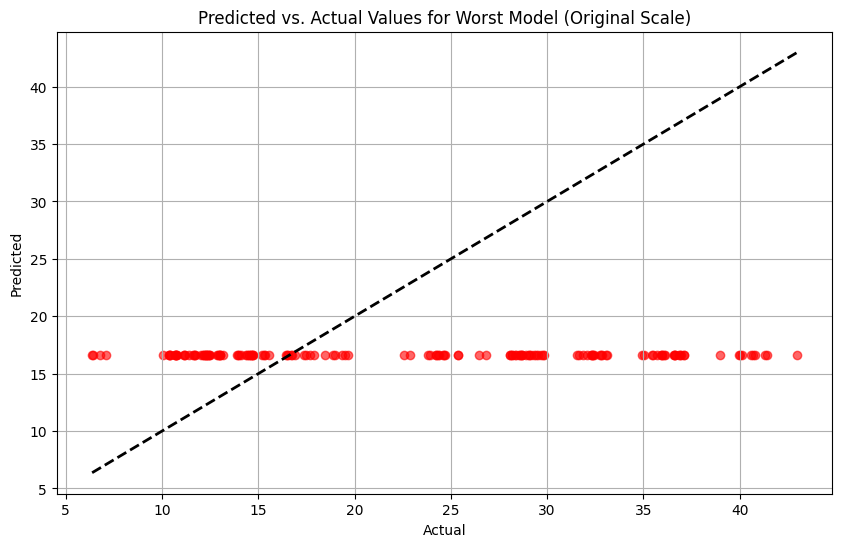

In [ ]:
# Instantiate a new SVR model with the worst parametfak lahers
worst_svr = SVR(C=worst_params['C'],
                epsilon=worst_params['epsilon'],
                kernel=worst_params['kernel'],
                degree=worst_params['degree'],
                gamma=worst_params['gamma'])

# Fit the model on your scaled training data
worst_svr.fit(X_train_scaled, y_train)

# Predict on your scaled test data
y_pred_worst = worst_svr.predict(X_test_scaled)

# Transform predictions and test set back to original scale
y_pred_worst_original = np.expm1(y_pred_worst)
y_test_original = np.expm1(y_test)

# Plotting Predicted vs. Actual Values for the worst model in the original scale
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_worst_original, alpha=0.6, color='r')
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], 'k--', lw=2)  # Diagonal line for reference
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs. Actual Values for Worst Model (Original Scale)')
plt.grid(True)
plt.show()


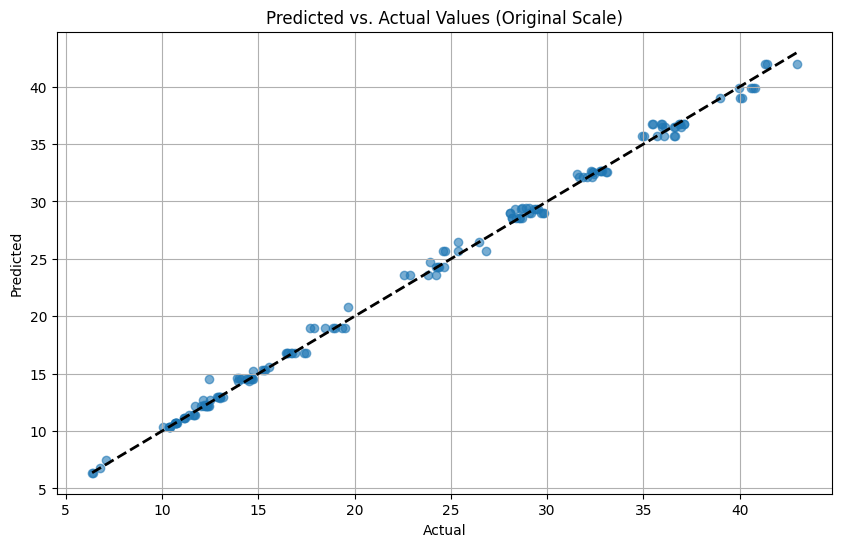

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_test_scaled)

# Transform predictions and test set back to original scale
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

# Plotting Predicted vs. Actual Values in the original scale
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.6)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], 'k--', lw=2)  # Diagonal line for reference
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs. Actual Values (Original Scale)')
plt.grid(True)
plt.show()

**Input test**

In this section we can try to input the data to predict Heating_Load

In [ ]:
def predict_load():
    # Input features from the user
    relative_compactness = float(input("Enter Relative Compactness: "))
    surface_area = float(input("Enter Surface Area: "))
    wall_area = np.log1p(float(input("Enter Wall Area: ")))
    roof_area = float(input("Enter Roof Area: "))
    overall_height = float(input("Enter Overall Height: "))
    glazing_area = float(input("Enter Glazing Area: "))

    # Create a DataFrame with the input features
    input_data = pd.DataFrame([[relative_compactness, surface_area, wall_area, roof_area, overall_height,
                                glazing_area]],
                              columns=['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
                                       'Glazing_Area'])

    # Scale the input features using the previously trained scaler
    input_data_scaled = scaler.transform(input_data)

    # Predict using the best model from GridSearchCV
    predicted_load = grid_search.best_estimator_.predict(input_data_scaled)
    original_scale_predictions = np.expm1(predicted_load)

    # Print the predicted load
    print(f"Predicted Heating Load: {original_scale_predictions[0]}")
# Call the function
predict_load()


#### Result and Analysis
In our analysis of Heating Load prediction, we embarked on a structured journey of data preprocessing and modeling. We began by splitting the dataset into training and testing sets, allocating 80% for training and 20% for testing. Feature scaling, achieved through the Standard Scaler, played a pivotal role in ensuring that all features were standardized and on the same scale, setting the stage for model training. The baseline model, Linear Regression, was our first choice, and it impressed us with an R-squared value of 93%, signifying a robust linear relationship between the features and Heating Load. This was a promising start, but our exploration didn't halt there, as we were eager to venture into more sophisticated models.

The spotlight then shifted to Support Vector Machines (SVM), a versatile and apt choice for this relatively small dataset. We initiated hyperparameter tuning through GridSearch to pinpoint the optimal hyperparameters. The tuning process considered parameters such as 'C' (regularization strength), 'epsilon' (epsilon-tube distance), 'kernel' (kernel function type), 'degree' (polynomial kernel degree), and 'gamma' (kernel coefficient). The results were remarkable, with the SVM model fine-tuned to its best configuration. The outcome was a highly accurate model, validated through various metrics, including Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared. These metrics unveiled the model's performance, demonstrating its proficiency in making precise predictions.

In the grand finale, the hyperparameter tuning exercise led us to the best hyperparameters for the SVM model: a regularization strength (C) of 10, a degree of 2, a small epsilon of 0.01, 'auto' for gamma, and the 'rbf' kernel. With this optimized SVM model, we achieved an extraordinary MAE and an impressive R-squared value of 0.996, signifying an outstanding fit to the data and the ability to make highly accurate predictions. To visually assess the model's prowess, a scatter plot was created, showcasing the alignment of predicted Heating Load values with their actual counterparts in the original scale. This visualization underscored the model's capability to closely match predictions with reality, emphasizing its exceptional performance and suitability for this specific dataset.

In summary, our journey through data preprocessing, modeling, and hyperparameter tuning led us from a strong baseline model to an exceptionally accurate Support Vector Machine for Heating Load prediction. This experience highlighted the power of hyperparameter tuning and the adaptability of SVM to a relatively small dataset, setting the stage for precise predictions of Heating Load.
